<center><h2>Explainable Machine Learning 2023/2024Z</h2></center>
<center><h3>Homework 6</h3></center>

Mateusz Szymański

# Task

The goal of this exercise is to calculate _Permutation-based Variable Importance_ (PVI) and compare the results with other feature importance methods: in our case this is _Gini importance_ (as feature importance method of decision trees) and mean absolute Shapley value.

## Dataset and model

Consistently, we are going to use `phoneme.csv` dataset. We skip details of this dataset as it has been explained thoroughly during previous homeworks.

Again, we stick to `RandomForestClassifier` decision model without any hyperparameter tuning. For the comparison we use a logistic regression model and `XGBClassifier`.

## Permutation-based Variable Importance

Let's present the PVI results for `RandomForestClassifier` on test data. We also take this opportunity to include _feature importance_ and mean absolute Shapley values for comparison.


| variable         |   dropout loss | feature importance | mean absolute Shapley values |
|:-----------------|---------------:|-------------------:|-----------------------------:|
| **full model**   |          0.068 |                  - |                            - |
| **V5**           |          0.103 |              0.129 |                        0.041 |
| **V2**           |          0.130 |              0.162 |                        0.066 |
| **V3**           |          0.148 |              0.148 |                        0.075 |
| **V1**           |          0.156 |              0.199 |                        0.069 |
| **V4**           |          0.158 |              0.301 |                        0.120 |
| **baseline**     |          0.503 |                  - |                            - |

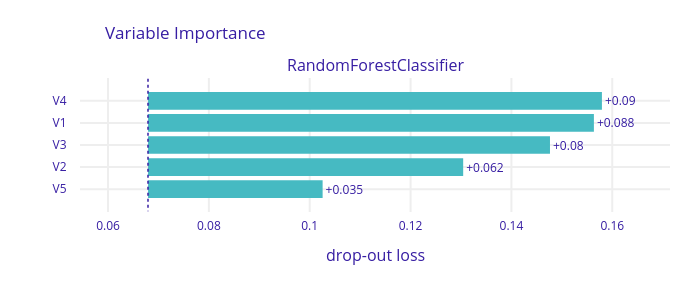</img>

### Comparison of different feature importance methods

One have to keep in mind that PVI and random forest feature importance values cannot be directly compared as they are calculated based on different rationales. However, the rank of certain variables may be compared (with a grain of salt) and reflect somehow the importance of certain variables. We can see that, which is consistent with previous analyses, that `V4` is the strongest indicator of the target variable followed by `V1`, and `V5` is the weakest variable. These two methods do not agree on the further variables, neither the strength relation between `V1` and `V4`: `V4` dominates in terms of _Gini importance_ while dropout loss is almost equal for both `V1` and `V4`.

On the other hand, _mean absolute Shapley values_ show some different things but they still however agree on the strongest and the weakest variables. Again, we cannot compare these values directly but the rank of variables may reveal something about feature importance.

Now, as we discussed differences in **results**, we need to address differences in **methods** to really answer the question why these results differ. We need also to understand the units of these feature importance metrics to begin with.

### PVI vs. _Gini importance_

_Permutation-based Variable Importance_ calculates the importance of each feature by evaluating how the evaluation metric (`1 - AUC` by default) degrades when the feature's relationship with the target variable is disrupted.

_Gini importance_ works on a different basis. The unit of the _Gini importance_ evaluation is, roughly speaking, the proportion of times a feature is used to split the data across all trees, derived from _Gini impurity_ measure. These values sum up to $1$.

These two techniques calculate different things. These methods are susceptible to different problems. For PVI we have the following:
* unreliable PVI values for strongly correlated features (this is not the case here however)
* sensitiveness to the choice of the metric

while _Gini importance_ is said:
* to rely on frequency of splits not the magnitude of Gini impurity decrease magnitude which may result in not accurately estimated feature importance
* to be biased towards features of bigger cardinality (this is however not the case here as the data is standarized)

### PVI vs. mean absolute Shapley values

As Shapley values have been described in earlier homeworks, as previously, mean absolute Shapley values as feature importance indicator is based on different mechanism and it basically measures average strength of Shapley value for each variable.

Again, Shapley values are of different unit (this time in model output unit) than previous methods. We cannot directly compare these results as there is no common ground for both values.

*One note*: Using Shapley values in a probability space may be not the best choice because of unjustified assumption of additivity (Shapley values are additive) but this is not a part of the scope of the exercise.

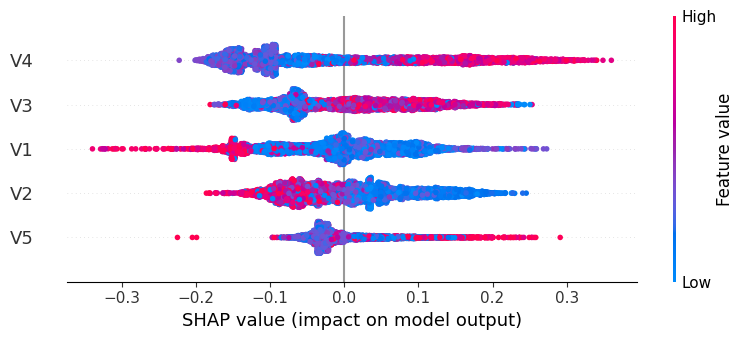</img>

## PVI for different models

| `RandomForestClassifier` | `LogisticRegression` | `XGBClassifier `|
|:------------------------:|:--------------------:|:---------------:|
| 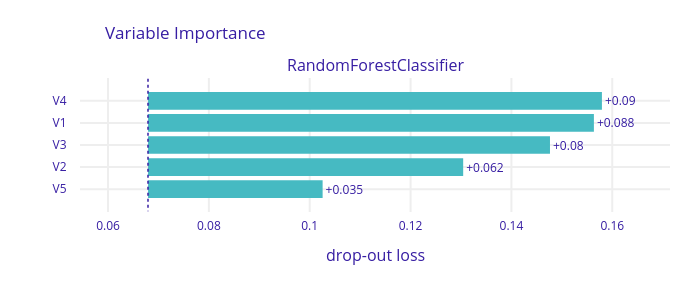</img> | 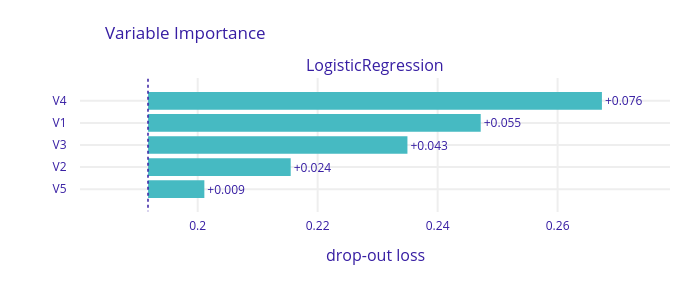</img> | 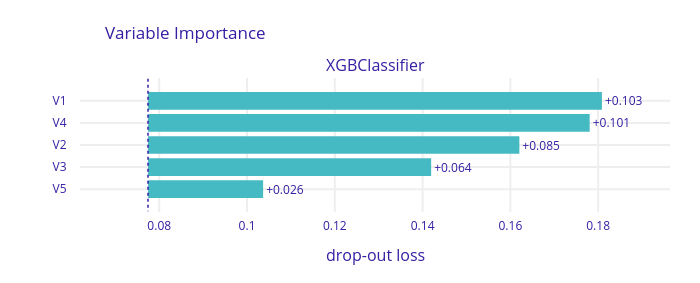</img> |

We can see that `RandomForestClassifier` and `LogisticRegression` agree more or less with each other. The rank of variables is preserved, however the `LogisticRegression` model attributes importances with higher variance.

On the other hand, `XGBClassifier` does not have the same order of features but, still, `V5` is universally the weakest variable. While `V1` is stronger than `V4`, the difference between attributed importance is quite small. `XGBClassifier` has different view also on the order between `V2` and `V3` in comparison with previous models.

It is quite hard to describe the source of differences. One thing is sure: the PVI method involves some randomness and the obtained results are of some variance. This can be easily verified by running PVI with `random_state=33` where `V4` goes to the first place:

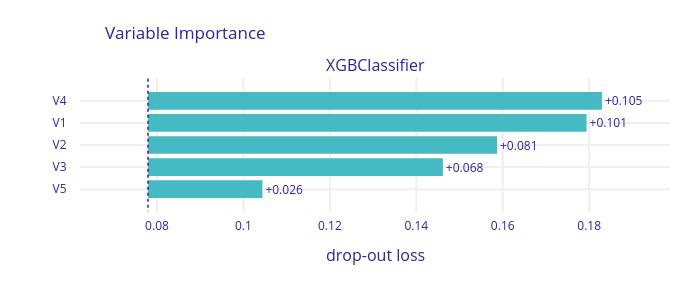</img>

But behaviour is quite rare and the order is rather stable. The models of choice behave differently and permutation of variables affects the performance in a different way.

# Appendix

## Package import

In [1]:
import random

import shap
import dalex as dx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.io import to_image
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

## Constants, auxiliary functions

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.75

NUM_COLUMNS = 5

In [3]:
def show_plotly_image(figure):
    image = to_image(figure)
    return Image(image)

In [4]:
def seed(random_state=RANDOM_STATE):
    np.random.seed(random_state)
    random.seed(random_state)


seed()

## Data preparation

In [5]:
df = pd.read_csv('datasets/phoneme.csv').iloc[:, 1:]
df['TARGET'] = df['TARGET'] - 1  # we shift the values as originally they are from the set {1, 2} instead of {1, 2}
X = df.iloc[:, :-1]
y = df.iloc[:, -1].to_numpy()

columns = df.columns[:NUM_COLUMNS]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [7]:
random_forest = RandomForestClassifier(random_state=RANDOM_STATE)
random_forest.fit(X_train, y_train)
print('Test accuracy: {:.2f}%.'.format(100 * random_forest.score(X_test, y_test)))

Test accuracy: 87.02%.


In [8]:
def random_forest_predict_proba(model, x):
    return model.predict_proba(x)[:, 1]

## PVI

In [9]:
explainer = dx.Explainer(
    random_forest,
    X_test, y_test,
    predict_function=random_forest_predict_proba
)

Preparation of a new explainer is initiated

  -> data              : 4053 rows 5 cols
  -> target variable   : 4053 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function random_forest_predict_proba at 0x7ff21beca0c0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.306, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.98, mean = -0.019, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


/home/mateusz/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [10]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.800516,0.756911,0.778103,0.868986,0.929481


,variable,dropout_loss,label
0,_full_model_,0.067942,RandomForestClassifier
1,V5,0.102557,RandomForestClassifier
2,V2,0.130433,RandomForestClassifier
3,V3,0.147646,RandomForestClassifier
4,V1,0.156358,RandomForestClassifier
5,V4,0.157948,RandomForestClassifier
6,_baseline_,0.502867,RandomForestClassifier


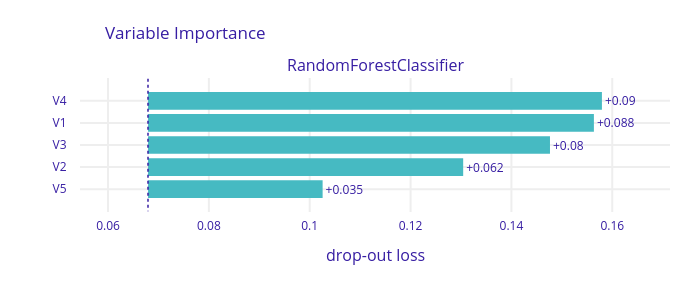

In [11]:
pvi = explainer.model_parts(random_state=RANDOM_STATE, loss_function='1-auc')
display(pvi.result)

figure = pvi.plot(show=False)
show_plotly_image(figure)

## _Gini impurity_

In [12]:
df_gini = pd.DataFrame({
    'Variable': columns,
    'Feature importance': random_forest.feature_importances_
}).set_index('Variable')
df_gini

,Feature importance
Variable,
V1,0.199188
V2,0.162220
V3,0.208704
V4,0.301254
V5,0.128634


## SHAP

In [13]:
seed()
shap_explainer = shap.TreeExplainer(random_forest, X)
shap_values = shap_explainer(X)
shap_values = shap_values.values[:, :, 1]

 99%|===================| 10688/10808 [01:21<00:00]        

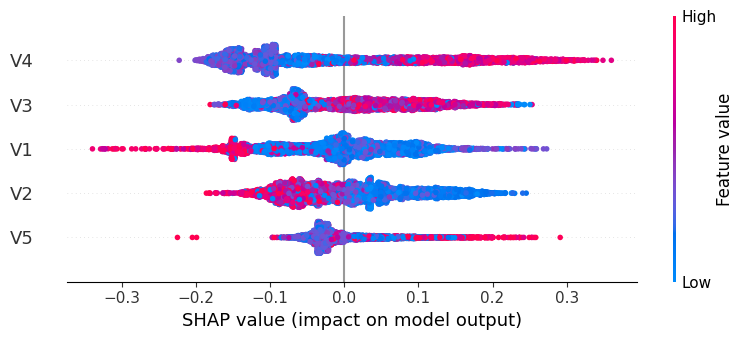

,feature,mean absolute SHAP value
3,V4,0.119655
2,V3,0.074807
0,V1,0.069155
1,V2,0.065692
4,V5,0.040827


In [14]:
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
shap.summary_plot(shap_values, X, feature_names=columns)

feature_importance = pd.DataFrame(
    list(zip(columns, mean_abs_shap_values)),
    columns=['feature', 'mean absolute SHAP value']
).sort_values(by='mean absolute SHAP value', ascending=False)
feature_importance

## Model comparison

In [15]:
logistic_regression = LogisticRegression(random_state=RANDOM_STATE)
logistic_regression.fit(X_train, y_train)
print('Test accuracy: {:.2f}%.'.format(100 * logistic_regression.score(X_test, y_test)))

Test accuracy: 76.56%.


In [16]:
explainer = dx.Explainer(
    logistic_regression,
    X_test, y_test
)

Preparation of a new explainer is initiated

  -> data              : 4053 rows 5 cols
  -> target variable   : 4053 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7ff21ca5efc0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0126, mean = 0.303, max = 0.872
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.864, mean = -0.0162, max = 0.978
  -> model_info        : package sklearn

A new explainer has been created!


/home/mateusz/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



,variable,dropout_loss,label
0,_full_model_,0.191732,LogisticRegression
1,V5,0.201114,LogisticRegression
2,V2,0.215507,LogisticRegression
3,V3,0.234967,LogisticRegression
4,V1,0.247182,LogisticRegression
5,V4,0.267388,LogisticRegression
6,_baseline_,0.500631,LogisticRegression


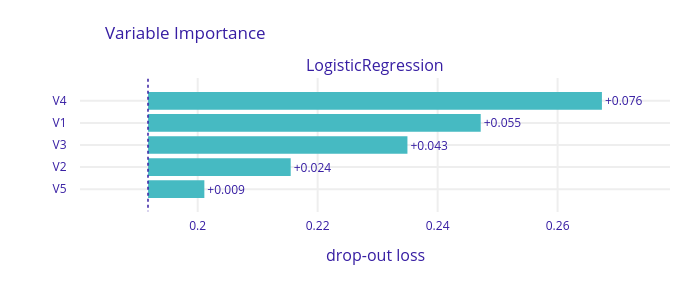

In [17]:
pvi = explainer.model_parts(random_state=RANDOM_STATE, loss_function='1-auc')
display(pvi.result)

figure = pvi.plot(show=False)
show_plotly_image(figure)

In [18]:
xgb = XGBClassifier(random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)
print('Test accuracy: {:.2f}%.'.format(100 * xgb.score(X_test, y_test)))

Test accuracy: 85.66%.


In [19]:
explainer = dx.Explainer(
    xgb,
    X_test, y_test
)

Preparation of a new explainer is initiated

  -> data              : 4053 rows 5 cols
  -> target variable   : 4053 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7ff21ca5efc0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.46e-05, mean = 0.296, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.999, mean = -0.00896, max = 1.0
  -> model_info        : package xgboost

A new explainer has been created!


,variable,dropout_loss,label
0,_full_model_,0.082132,XGBClassifier
1,V5,0.106443,XGBClassifier
2,V3,0.149877,XGBClassifier
3,V2,0.166581,XGBClassifier
4,V4,0.181762,XGBClassifier
5,V1,0.186974,XGBClassifier
6,_baseline_,0.504449,XGBClassifier


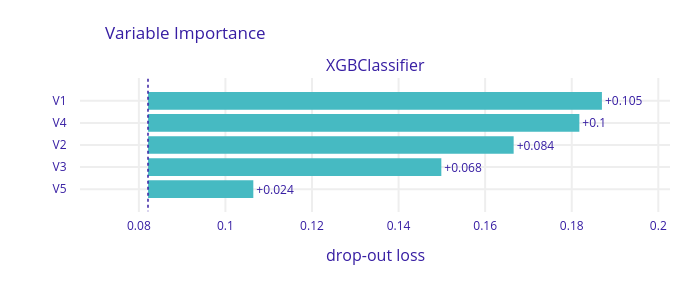

In [20]:
pvi = explainer.model_parts(random_state=RANDOM_STATE - 1, loss_function='1-auc')
display(pvi.result)

figure = pvi.plot(show=False)
show_plotly_image(figure)

,variable,dropout_loss,label
0,_full_model_,0.077451,XGBClassifier
1,V5,0.103667,XGBClassifier
2,V3,0.141950,XGBClassifier
3,V2,0.162051,XGBClassifier
4,V4,0.178070,XGBClassifier
5,V1,0.180860,XGBClassifier
6,_baseline_,0.505076,XGBClassifier


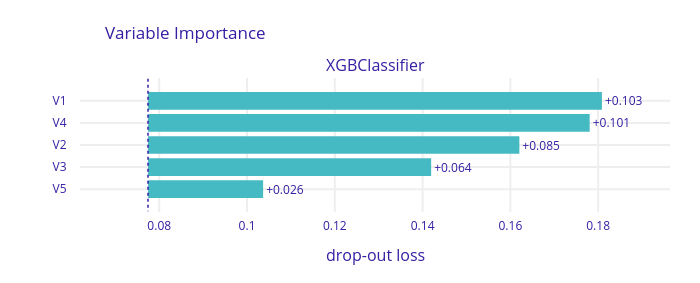

In [21]:
pvi = explainer.model_parts(random_state=RANDOM_STATE, loss_function='1-auc')
display(pvi.result)

figure = pvi.plot(show=False)
show_plotly_image(figure)

,variable,dropout_loss,label
0,_full_model_,0.077933,XGBClassifier
1,V5,0.104388,XGBClassifier
2,V3,0.146145,XGBClassifier
3,V2,0.158673,XGBClassifier
4,V1,0.179395,XGBClassifier
5,V4,0.182952,XGBClassifier
6,_baseline_,0.497352,XGBClassifier


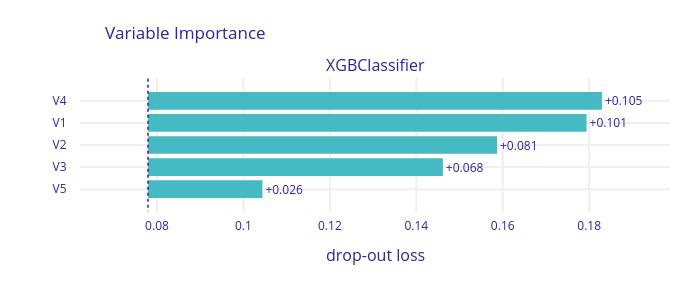

In [22]:
seed()
pvi = explainer.model_parts(random_state=33, loss_function='1-auc')
display(pvi.result)

figure = pvi.plot(show=False)
show_plotly_image(figure)